In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, autograd
from torch.nn import functional as F

import numpy as np
import scipy.spatial
import math
import os
import pyemma as pe
USE_GPU = torch.cuda.is_available()

In [3]:
Dx = 2
N =10000
kBT = 20
repeat_times = 100
os.makedirs('./Data', exist_ok=True)

In [4]:
aa = [-1, -1, -6.5, 0.7]
bb = [0, 0, 11, 0.6]
cc = [-10, -10, -6.5, 0.7]
AA = [-200, -100, -170, 15]
XX = [1, 0, -0.5, -1]
YY = [0, 0.5, 1.5, 1]
sigma = 0.05



/Users/junowang/anaconda3/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


In [4]:
def get_V(px):
    px = np.array(px)
    ee = 0
    if USE_GPU:
        px = px.cuda()
        ee = ee.cuda()
    if np.size(px.shape) == 2:
        for j in range(4):
            ee = ee + AA[j] * np.exp(aa[j] * (px[:, 0] - XX[j]) ** 2 +
                                              bb[j] * (px[:, 0] - XX[j]) * (px[:, 1] - YY[j]) +
                                              cc[j] * (px[:, 1] - YY[j]) ** 2)
        ee += 9 * np.sin(2 * 5 * np.pi * px[:, 0]) * np.sin(2 * 5 * np.pi * px[:, 1])
        for i in range(2, Dx):
            ee += px[:, i] ** 2 / 2 / sigma ** 2
    else:
        for j in range(4):
            ee = ee + AA[j] * np.exp(aa[j] * (px[0] - XX[j]) ** 2 +
                                              bb[j] * (px[0] - XX[j]) * (px[1] - YY[j]) +
                                              cc[j] * (px[1] - YY[j]) ** 2)
        ee += 9 * np.sin(2 * 5 * np.pi * px[0]) * np.sin(2 * 5 * np.pi * px[1])
        for i in range(2, Dx):
            ee += px[i] ** 2 / 2 / sigma ** 2
    return ee

In [5]:
def get_grad(px):
    px = np.array(px)
    gg = np.zeros(shape=(Dx,), dtype=np.float64)
    if USE_GPU:
        px = px.cuda()
        gg = gg.cuda()
    for j in range(4):
        ee = AA[j] * np.exp(aa[j] * (px[0] - XX[j]) ** 2 +
                                     bb[j] * (px[0] - XX[j]) * (px[1] - YY[j]) +
                                     cc[j] * (px[1] - YY[j]) ** 2)
        gg[0] = gg[0] + (2 * aa[j] * (px[0] - XX[j]) +
                             bb[j] * (px[1] - YY[j])) * ee
        gg[1] = gg[1] + (bb[j] * (px[0] - XX[j]) +
                             2 * cc[j] * (px[1] - YY[j])) * ee
    gg[0] += 9 * 2 * 5 * np.pi * np.cos(2 * 5 * np.pi * px[0]) * np.sin(2 * 5 * np.pi * px[1])
    gg[1] += 9 * 2 * 5 * np.pi * np.sin(2 * 5 * np.pi * px[0]) * np.cos(2 * 5 * np.pi * px[1])
    for i in range(2, Dx):
        gg[i] = px[i] / sigma ** 2
    return gg

In [6]:
def sim_data(px_init, kBT, dt, D_size, firstsave=1000, t_sep=100):
    D = []
    px = px_init
    id_ = 0
    i = 0
    if USE_GPU:
        D = D.cuda()
        px = px.cuda()
    while True:
        px = px - dt * get_grad(px) + np.sqrt(2 * kBT * dt) * np.random.normal(size=(Dx,))
        if i >= firstsave and i % t_sep == 0 and 1 >= px[0] >= -1.5 \
                and 2 >= px[1] >= -0.5:
            D.append(px)
            id_ += 1
            if id_ >= D_size:
                break
        i += 1
    data = np.zeros((D_size, 1 + Dx))
    data[:, 1:] = np.array(D)
    data[:, 0] = get_V(D)
#     print('generating data finished!')
    return data

In [55]:
data_ori = []
for i in range(repeat_times):
    x1 = np.random.uniform(low = -1.0, high = 1.0)
    x2 = np.random.uniform(low = -1.0, high = 1.0)
    px_init = np.zeros((Dx,))
    px_init[0] = x1
    px_init[1] = x2
    data_ori_t = sim_data(px_init = px_init, kBT = kBT, dt = 1e-5, D_size = N)
    data_ori.extend(data_ori_t)
print(np.shape(data_ori))

KeyboardInterrupt: 

In [49]:
np.savetxt('Data/data_'+str(N)+'_'+str(kBT)+'_'+str(repeat_times), data_ori)

In [5]:
data_ori = np.loadtxt('Data/data_'+str(N)+'_'+str(kBT)+'_'+str(repeat_times)).reshape(-1,Dx+1)

In [6]:
print(np.shape(data_ori))

(1000000, 3)


Text(0, 0.5, 'x2')

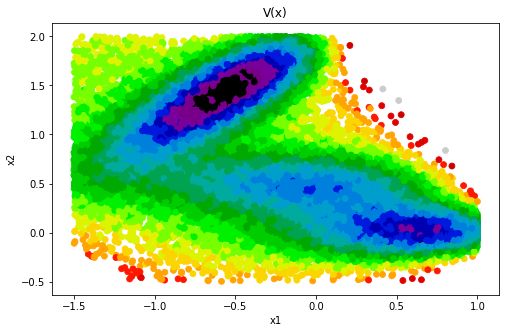

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(data_ori[:, 1], data_ori[:, 2], marker='o',lw = 0.75,c=data_ori[:,0], cmap = plt.cm.get_cmap('nipy_spectral', 20))
ax.set_title('V(x)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6d8b4a240>)

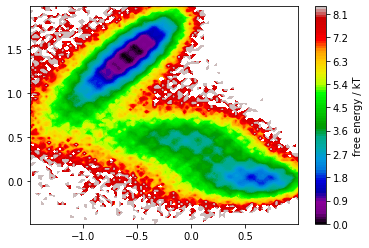

In [8]:
pe.plots.plot_free_energy(data_ori[:,1],data_ori[:,2])

In [23]:
X0 = torch.from_numpy(data_ori[:20000, 1:]).float()
print(X0.size())

X1 = torch.from_numpy(data_ori[100:20100, 1:]).float()
print(X1.size())

torch.Size([20000, 2])
torch.Size([20000, 2])


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6d5770358>)

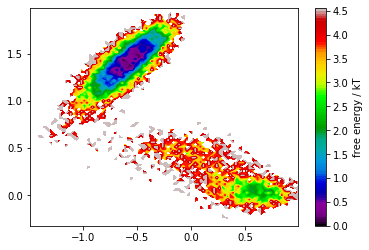

In [24]:
pe.plots.plot_free_energy(X0[:,0].numpy(),X0[:,1].numpy())

In [25]:
train_batch_size = 128

train_loader = torch.utils.data.DataLoader(
    torch.cat([X0, X1], 1), batch_size = train_batch_size, shuffle = True)

In [26]:

Dr = 1


R_net = nn.Sequential(
    nn.Linear(Dx, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, Dr)
    )

D_net = nn.Sequential(
    nn.Linear(Dx + Dr, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.LogSoftmax()
    )


In [27]:
lr = 1e-5
optimizer = optim.Adam(list(R_net.parameters()) + list(D_net.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

n_epochs = 40
train_data_size = len(train_loader.dataset)
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):

        actual_size = len(data)
        data = data
        data_X0 = data[:, :Dx]
        data_X1 = data[:, Dx:2*Dx]
        #rand_ind = np.random.choice(train_data_size, actual_size, replace=False)
        #data_iX1 = train_loader.dataset[rand_ind, Dx:2*Dx].to(device)
        data_iX1 = data_X1[torch.randperm(actual_size)]
        R0 = R_net(data_X0)
        D_J = D_net(torch.cat([R0, data_X1], 1))[:,0]
        D_I = D_net(torch.cat([R0, data_X1], 1))[:,1]
        loss = -D_J.mean() - D_I.mean()

        train_loss += loss.item() * len(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    
    if epoch % 1 == 0:
        print('Train Epoch: {} ===> Train set loss: {:.4f}'.format(epoch, train_loss))
    
    scheduler.step()

Train Epoch: 1 ===> Train set loss: 8.1517
Train Epoch: 2 ===> Train set loss: 8.0736
Train Epoch: 3 ===> Train set loss: 7.9733
Train Epoch: 4 ===> Train set loss: 7.8307
Train Epoch: 5 ===> Train set loss: 7.6301
Train Epoch: 6 ===> Train set loss: 7.3193
Train Epoch: 7 ===> Train set loss: 6.7692
Train Epoch: 8 ===> Train set loss: 5.7794
Train Epoch: 9 ===> Train set loss: 4.1001
Train Epoch: 10 ===> Train set loss: 2.4321
Train Epoch: 11 ===> Train set loss: 1.7632
Train Epoch: 12 ===> Train set loss: 1.5624
Train Epoch: 13 ===> Train set loss: 1.4836
Train Epoch: 14 ===> Train set loss: 1.4453
Train Epoch: 15 ===> Train set loss: 1.4250
Train Epoch: 16 ===> Train set loss: 1.4133
Train Epoch: 17 ===> Train set loss: 1.4060
Train Epoch: 18 ===> Train set loss: 1.4012
Train Epoch: 19 ===> Train set loss: 1.3978
Train Epoch: 20 ===> Train set loss: 1.3954
Train Epoch: 21 ===> Train set loss: 1.3937
Train Epoch: 22 ===> Train set loss: 1.3923
Train Epoch: 23 ===> Train set loss: 1.39

In [28]:
R = R_net(X0).detach().numpy()
print(np.shape(R))
x1 = X0[:,0].numpy()
x2 = X0[:,1].numpy()
print(np.shape(x1))
print(np.shape(x2))

(20000, 1)
(20000,)
(20000,)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6c3860d30>)

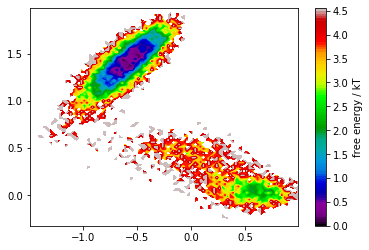

In [29]:
pe.plots.plot_free_energy(x1,x2)

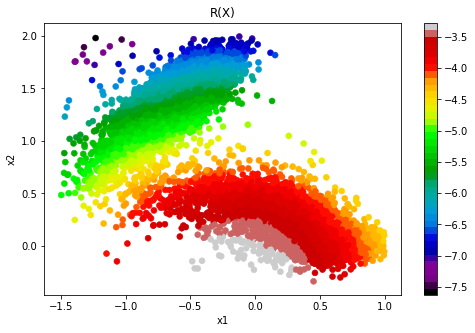

In [30]:
# R = R_net(X0.to(device))
# plt.plot(X0_bar.cpu().detach().numpy()[:, 0], R.cpu().detach().numpy()[:, 0], 'o')

fig, ax = plt.subplots(figsize=(8, 5))
Rd1 = ax.scatter(x1.reshape(-1,1), x2.reshape(-1,1), marker='o',lw = 0.5, c = R, cmap = plt.cm.get_cmap('nipy_spectral', 40))
ax.set_title('R(X)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.colorbar(Rd1)